<div style="background-color: darkslategray; color: white; padding: 15px; border-radius: 8px;">
    <center><h1 style="font-family: Arial, sans-serif;">Predicting Rare Species</h1></center>
    <center><h3 style="font-family: Arial, sans-serif;">Deep Learning Project</h3></center>
</div>

**<h3>Table of Contents</h3>**
* [1. Environment Setup](#1-environment-setup)
* [2. Exploratory Data Analysis](#2-exploratory-data-analysis)
* [3. Feature Engineering](#3-feature-engineering)
* [4. Splitting the Dataset](#4-splitting-the-dataset)
* [5. Preprocessing - testing](#5-preprocessing---testing)


<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

In this section we:
- import the necessary libraries for this notebook
- import the dataset

## 1.1 Connect Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [1]:
# # # Google Colab
# !pip install keras_cv

In [2]:
from classes import *
from functions import *

import pandas as pd
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, regularizers
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (
    Concatenate, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D,
    Input, MaxPooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pickle
import zipfile
from pathlib import Path

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [3]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [4]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

In [5]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Exploratory Data Analysis

<div>

In this section we:
- check distributions of the features of the metadata dataset
- check amount of families per phylum
- check for possible anomalies

Main takeaways:
- all images belong to the animalia kingdom
- chordata is the dominant phylum by a great margin
- 118 (out of 202) families account for less than 0.25 percent of total observations. We define these as minority classes


In [6]:
df.columns

Index(['rare_species_id', 'eol_content_id', 'eol_page_id', 'kingdom', 'phylum',
       'family', 'file_path'],
      dtype='object')

#### Kingdom

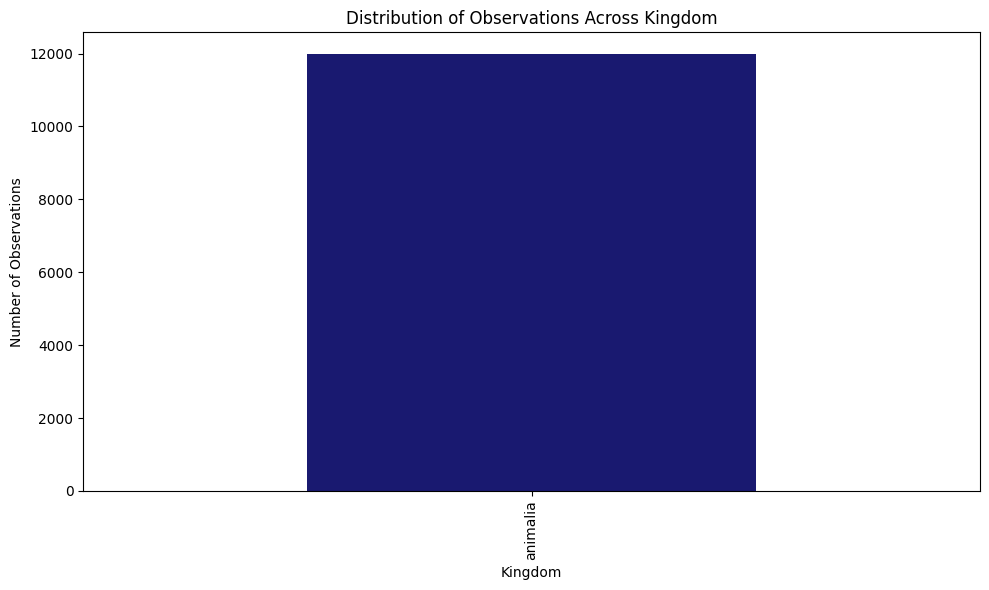

In [7]:
kingdom_counts = df['kingdom'].value_counts()
plot_graph(title='Distribution of Observations Across Kingdom', xlabel='Kingdom', ylabel='Number of Observations',  counts=kingdom_counts)

#### Phylum

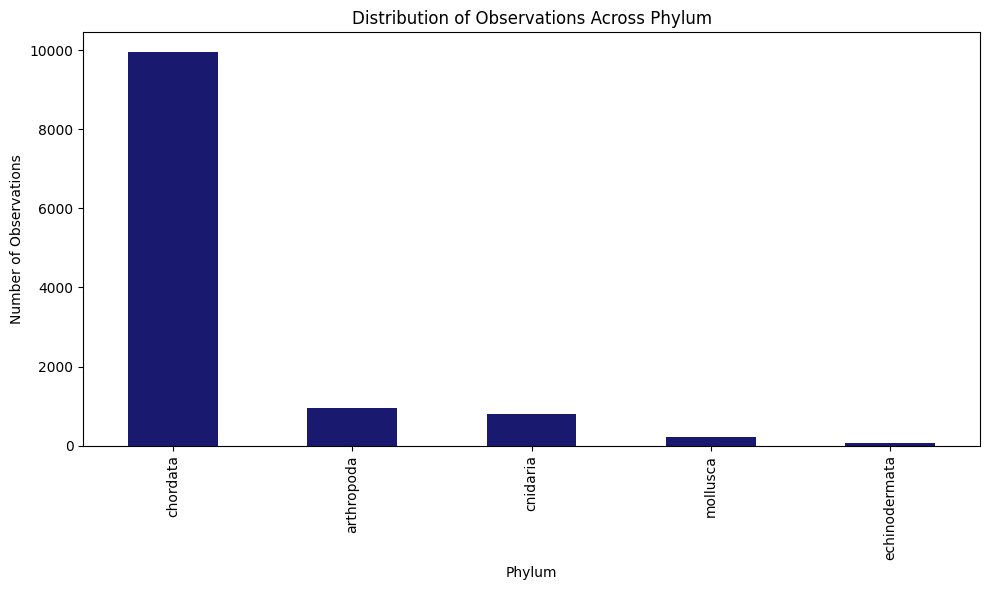

In [8]:
phylum_counts = df['phylum'].value_counts()
plot_graph(title='Distribution of Observations Across Phylum', xlabel='Phylum', ylabel='Number of Observations',  counts=phylum_counts)

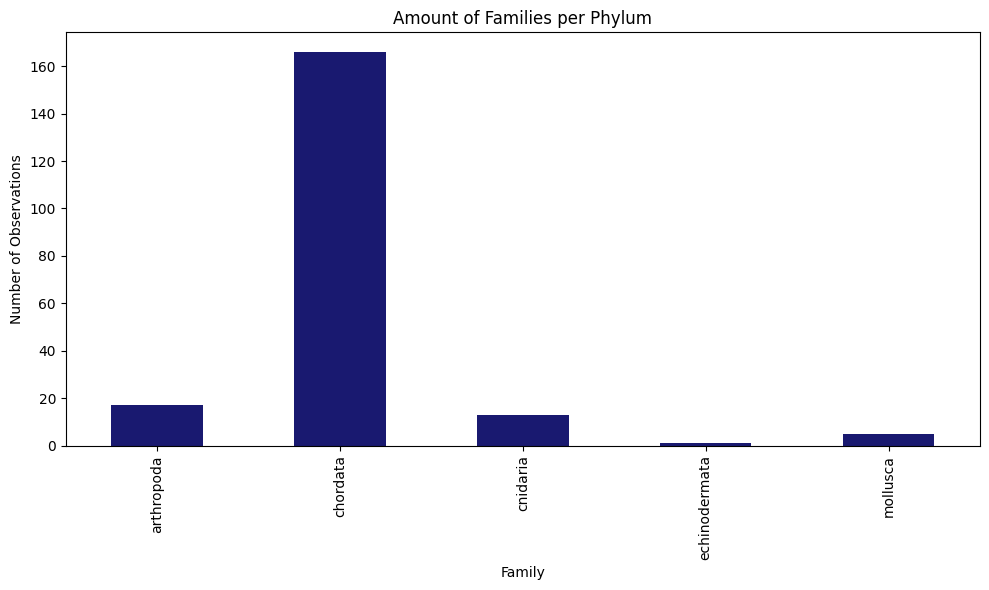

phylum
arthropoda        17
chordata         166
cnidaria          13
echinodermata      1
mollusca           5
Name: family, dtype: int64


In [9]:
family_phylum_counts = df.groupby("phylum")["family"].nunique()
plot_graph(title='Amount of Families per Phylum', xlabel='Family', ylabel='Number of Observations',  counts=family_phylum_counts)
print(family_phylum_counts)

#### Family

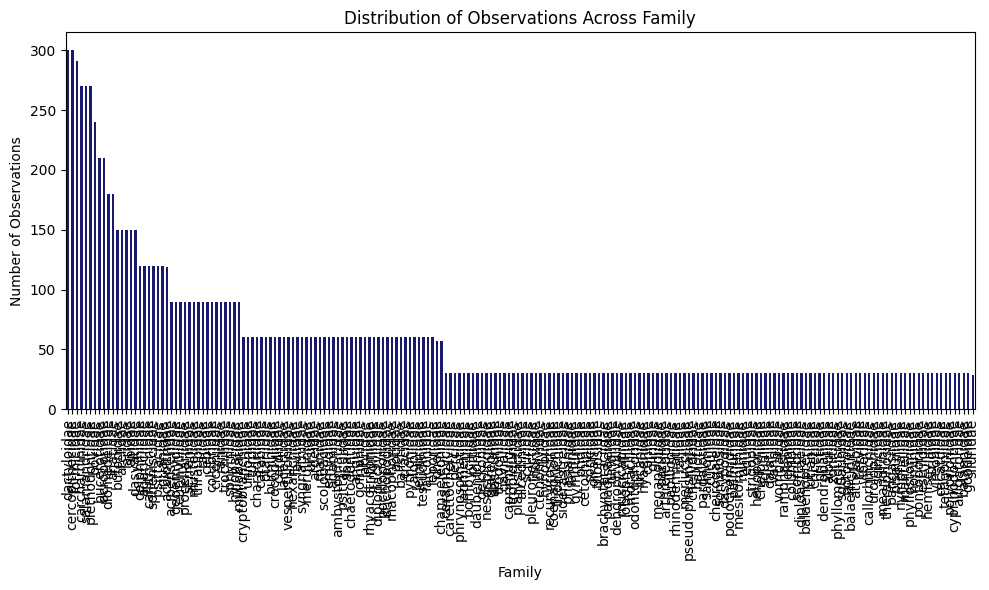

In [10]:
family_counts = df['family'].value_counts()
plot_graph(title='Distribution of Observations Across Family', xlabel='Family', ylabel='Number of Observations',  counts=family_counts)

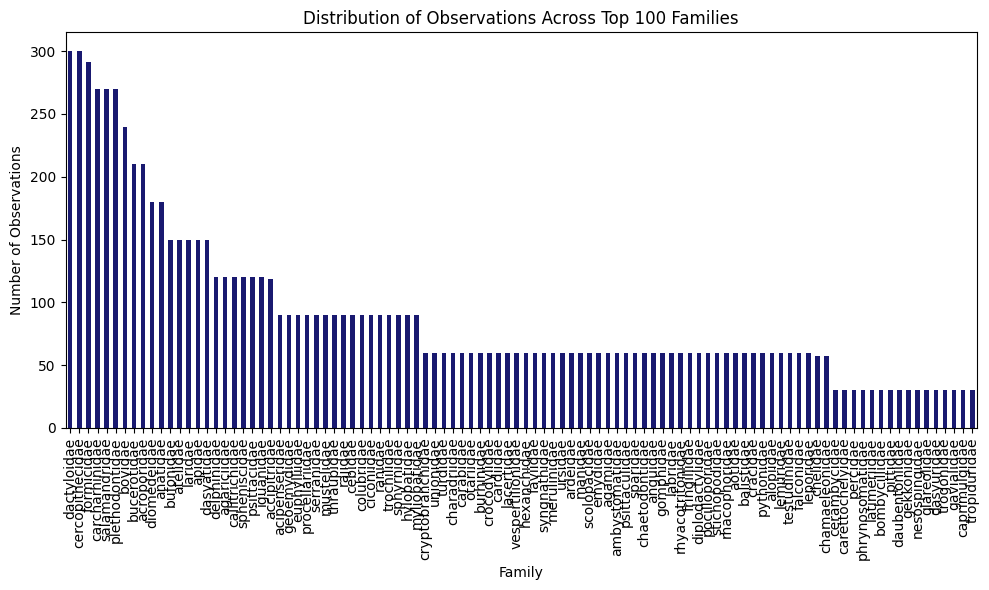

In [11]:
top_100_families = df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations Across Top 100 Families', xlabel='Family', ylabel='Number of Observations',  counts=top_100_families)

In [12]:
family_counts = df["family"].value_counts(normalize=True)*100

df_family_proportions = pd.DataFrame({
    "Family": family_counts.index,
    "Proportion (%)": family_counts.values  
})

df_family_proportions # 202 different families

Family  Proportion (%)
0        dactyloidae        2.503547
1    cercopithecidae        2.503547
2         formicidae        2.428440
3     carcharhinidae        2.253192
4      salamandridae        2.253192
..               ...             ...
197  cyprinodontidae        0.250355
198    alligatoridae        0.250355
199       balaenidae        0.250355
200        goodeidae        0.250355
201        siluridae        0.242010

[202 rows x 2 columns]

In [13]:
num_families_025 = int((df_family_proportions["Proportion (%)"] <= 0.2505).sum())
num_families_025 # 118 families have less than 0.2505% of images

118

Mean images per family: 59.32
Median images per family: 30.00
Skewness: 2.72
The distribution is right-skewed.


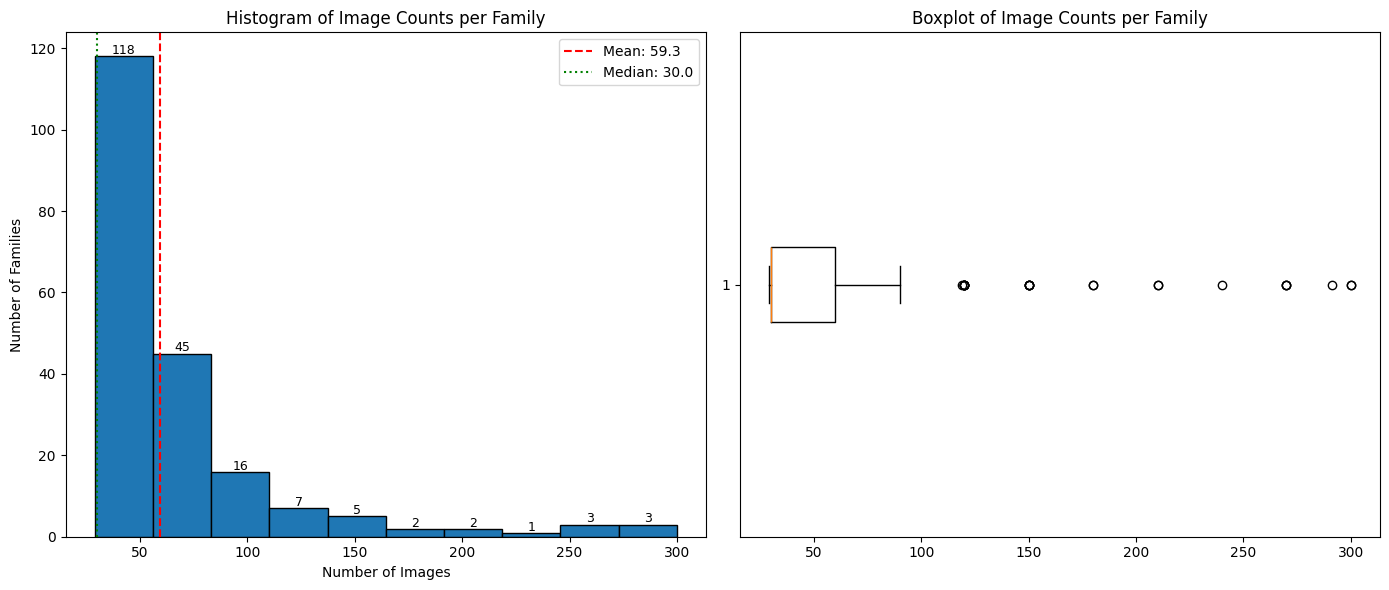

In [14]:
family_counts = df['family'].value_counts()
mean_count = family_counts.mean()
median_count = family_counts.median()
skewness_val = skew(family_counts)

thresholds = [30, 50, 100, 150]
absolute_counts = {t: (family_counts < t).sum() for t in thresholds}
relative_counts = {t: (c / len(family_counts)) * 100 for t, c in absolute_counts.items()}

print(f"Mean images per family: {mean_count:.2f}")
print(f"Median images per family: {median_count:.2f}")
print(f"Skewness: {skewness_val:.2f}")
print("The distribution is right-skewed." if skewness_val > 0 else (
    "The distribution is left-skewed." if skewness_val < 0 else "The distribution is symmetric."))

plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(family_counts, bins=10, edgecolor='black')
for i in range(len(n)):
    plt.text((bins[i]+bins[i+1])/2, n[i]+0.5, str(int(n[i])), ha='center', fontsize=9)
plt.axvline(mean_count, color='red', linestyle='dashed', label=f'Mean: {mean_count:.1f}')
plt.axvline(median_count, color='green', linestyle='dotted', label=f'Median: {median_count:.1f}')
plt.title("Histogram of Image Counts per Family")
plt.xlabel("Number of Images")
plt.ylabel("Number of Families")
plt.legend()

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(family_counts.values, vert=False)
plt.title("Boxplot of Image Counts per Family")

plt.tight_layout()
plt.show()

In [15]:
top_84_family_proportion_sum = df_family_proportions.iloc[:84]["Proportion (%)"].sum()
top_84_family_proportion_sum # although 118 families represent less than 0.25% of the dataset, the 84 that have >0.25% represent only 70.46% of the dataset

np.float64(70.46649420011681)

<!-- is it better to predict phylum and then family or a concatenation of the two? -->

In [16]:
df['family'].value_counts().tail(100)

family
sciuridae          30
pleuronectidae     30
indriidae          30
ctenomyidae        30
hynobiidae         30
                   ..
cyprinodontidae    30
alligatoridae      30
balaenidae         30
goodeidae          30
siluridae          29
Name: count, Length: 100, dtype: int64

In [17]:
minority_class = df['family'].value_counts()[df['family'].value_counts() <= 30].index
minority_class=minority_class.to_list()

In [20]:
anomaly_counts = df.groupby("family")["phylum"].nunique()
anomaly_counts.value_counts() # there are no families that belong to more than 1 phylum

phylum
1    202
Name: count, dtype: int64

<div class="alert alert-block alert-success">

# **3.** Feature Engineering 

<div>

In this section we:
- One-hot encode phylum and family, and store the encoders with pickle for use in other notebooks

In [21]:
# creating the encoders
family_encoder = LabelEncoder()
phylum_encoder = LabelEncoder()
df["family_encoded"] = family_encoder.fit_transform(df["family"])
df["phylum_encoded"] = phylum_encoder.fit_transform(df["phylum"])

# saving them
with open('family_encoder.pkl', 'wb') as f:
    pickle.dump(family_encoder, f)
with open('phylum_encoder.pkl', 'wb') as f:
    pickle.dump(phylum_encoder, f)

# checking its ok
num_families = len(family_encoder.classes_)
num_phyla = len(phylum_encoder.classes_)
print(f"Number of unique phyla: {num_phyla}")
print(f"Number of unique families: {num_families}")

Number of unique phyla: 5
Number of unique families: 202


In [ ]:
# storing the onehot encode on the dataset
family_onehots = tf.one_hot(df["family_encoded"].values, depth=num_families).numpy()
phylum_onehots = tf.one_hot(df["phylum_encoded"].values, depth=num_phyla).numpy()
df["family_onehot"] = list(family_onehots)
df["phylum_onehot"] = list(phylum_onehots)

# creating new column for the full file path
# Windows
path = Path("../data/rare_species")
df["full_file_path"] = df["file_path"].apply(lambda x: path / x) 
# Mac
# df["full_file_path"] = df["file_path"].apply(lambda x: str(Path("../data/rare_species") / x))

df.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  family_encoded  \
0  mollusca_unionidae/12853737_449393_eol-full-si...             193   
1  chordata_geoemydidae/20969394_793083_eol-full-...              84   
2  chordata_cryptobranchidae/28895411_319982_eol-...              56   
3  chordata_turdidae/29658536_45510188_eol-full-s...             192   
4  chordata_indriidae/21252576_7250886_eol-full-s...             100   

   phylum_encoded                                      family_onehot  \
0               4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1               1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2               1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

               phylum_onehot  \
0  [0.0, 0.0, 0.0, 0.0, 1.0]   
1  [0.0, 1.0, 0.0, 0.0, 0.0]   
2  [0.0, 1.0, 0.0, 0.0, 0.0]   
3  [0.0, 1.0, 0.0, 0.0, 0.0]   
4  [0.0, 1.0, 0.0, 0.0, 0.0]   

                                      full_file_path  
0  ..\data\rare_species\mollusca_unionidae\128537...  
1  ..\data\rare_species\chordata_geoemydidae\2096...  
2  ..\data\rare_species\chordata_cryptobranchidae...  
3  ..\data\rare_species\chordata_turdidae\2965853...  
4  ..\data\rare_species\chordata_indriidae\212525...

In [27]:
df['full_file_path'][0]

WindowsPath('../data/rare_species/mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg')

<div class="alert alert-block alert-success">

# **4.** Splitting the Dataset

<div>

In this section we:
- Split all the images into: train (70%), validation (15%), and test (15%)
- Alter the data/... structure into data/train/..., data/val/..., and data/test/... (necessary for our functions and methods, used in the remaining notebooks)
- Export each dataset into pickle files
- Create a sample of the train set half its size

In [ ]:
# data split
train_df, test_val_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42, stratify=df['family'])
val_df, test_df = train_test_split(test_val_df, test_size=0.5, shuffle=True, random_state=42, stratify=test_val_df['family'])
train_df_sampled, _ = train_test_split(train_df, test_size=0.5, shuffle=True, random_state=42, stratify=train_df['family'])

In [ ]:
# organizing the data into train/val/test directories using our custom functions
image_base_path = Path("../data/rare_species")
base_output_dir = image_base_path

organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df, copy=False, split_name="train")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=val_df, copy=False, split_name="val")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=test_df, copy=False, split_name="test")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df_sampled, copy=False, split_name="train_sampled")

cleanup_folders(image_base_path)

train_df = update_paths(train_df, "train")
val_df = update_paths(val_df, "val")
test_df = update_paths(test_df, "test")
train_df_sampled = update_paths(train_df_sampled, "train_sampled")

In [ ]:
# exporting each DataFrame as a .pkl file
with open("../data/train_df.pkl", "wb") as f:
     pickle.dump(train_df, f)

with open("../data/val_df.pkl", "wb") as f:
     pickle.dump(val_df, f)

with open("../data/test_df.pkl", "wb") as f:
     pickle.dump(test_df, f)

with open("../data/train_df_sampled.pkl", "wb") as f:
     pickle.dump(train_df_sampled, f)

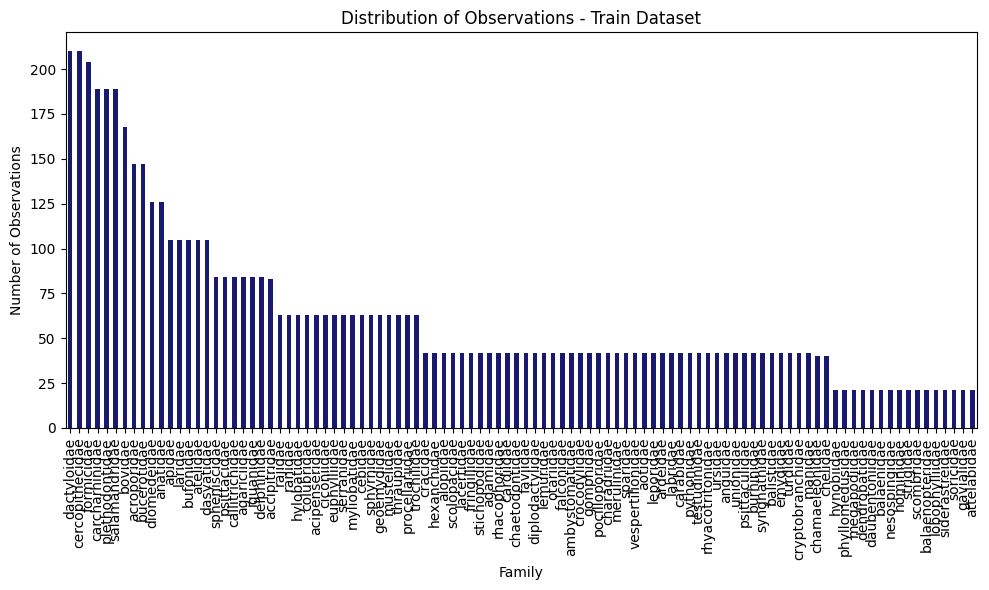

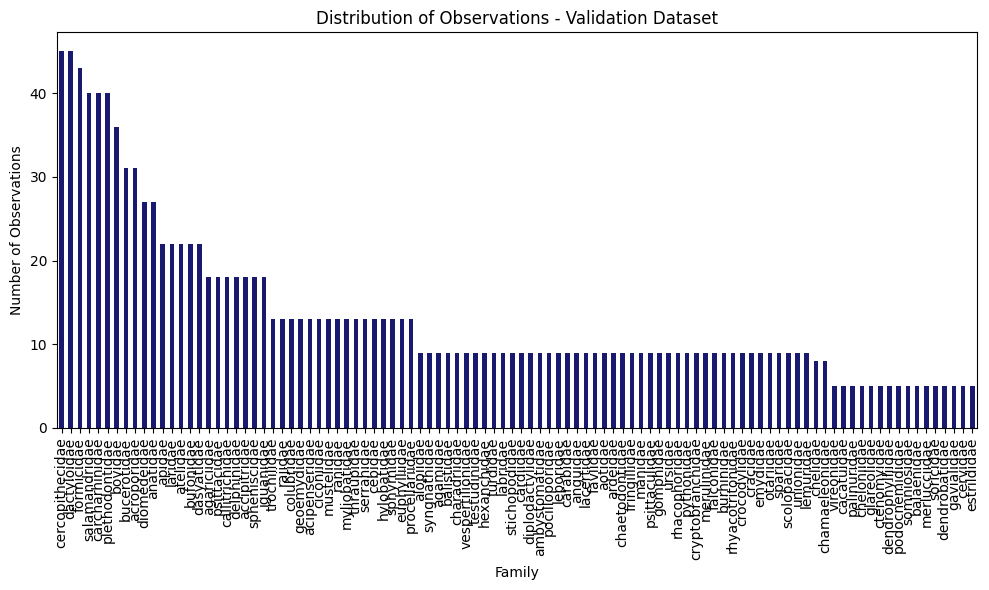

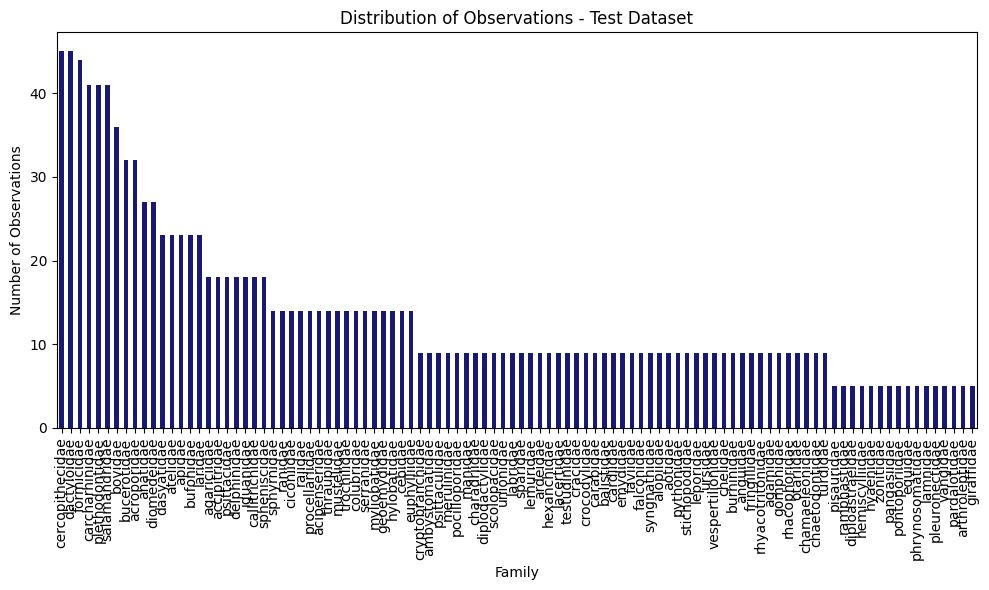

In [37]:
train_df_counts = train_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Train Dataset', xlabel='Family', ylabel='Number of Observations',  counts=train_df_counts )

valid_df_counts = val_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Validation Dataset', xlabel='Family', ylabel='Number of Observations',  counts=valid_df_counts )

test_df_counts = test_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Test Dataset', xlabel='Family', ylabel='Number of Observations',  counts=test_df_counts )

In [38]:
print(f"Training samples: {len(train_df)}")
print(f"Training sampled samples: {len(train_df_sampled)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 8388
Training sampled samples: 4194
Validation samples: 1797
Testing samples: 1798


<div class="alert alert-block alert-success">

# **5.** Preprocessing - testing

<div>

(After having run the previous sections once, this section can run independently, as it loads the pickle files)

In this section we:
- apply our preprocessing pipeline to the datasets (using our Preprocessor class and the .load_img method), and visually inspect the results to check

Preprocessing logic:
- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1])
- Resizes images to a fixed size (e.g., 224x224 pixels)
- Oversampling (only during training)
- Applies augmentation (only during training)
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time)

In [ ]:
# loading the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/val_df.pkl", "rb") as f:
     val_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

with open("../data/train_df_sampled.pkl", "rb") as f:
     train_df_sampled = pickle.load(f)

with open("../data/family_encoder.pkl", "rb") as f:
     family_encoder = pickle.load(f)

In [42]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [ ]:
batch_size = 32 # the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

In [44]:
train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment='mixup', oversampling=True, shuffle=True)
# train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment=None, oversampling=True, shuffle=True)
val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


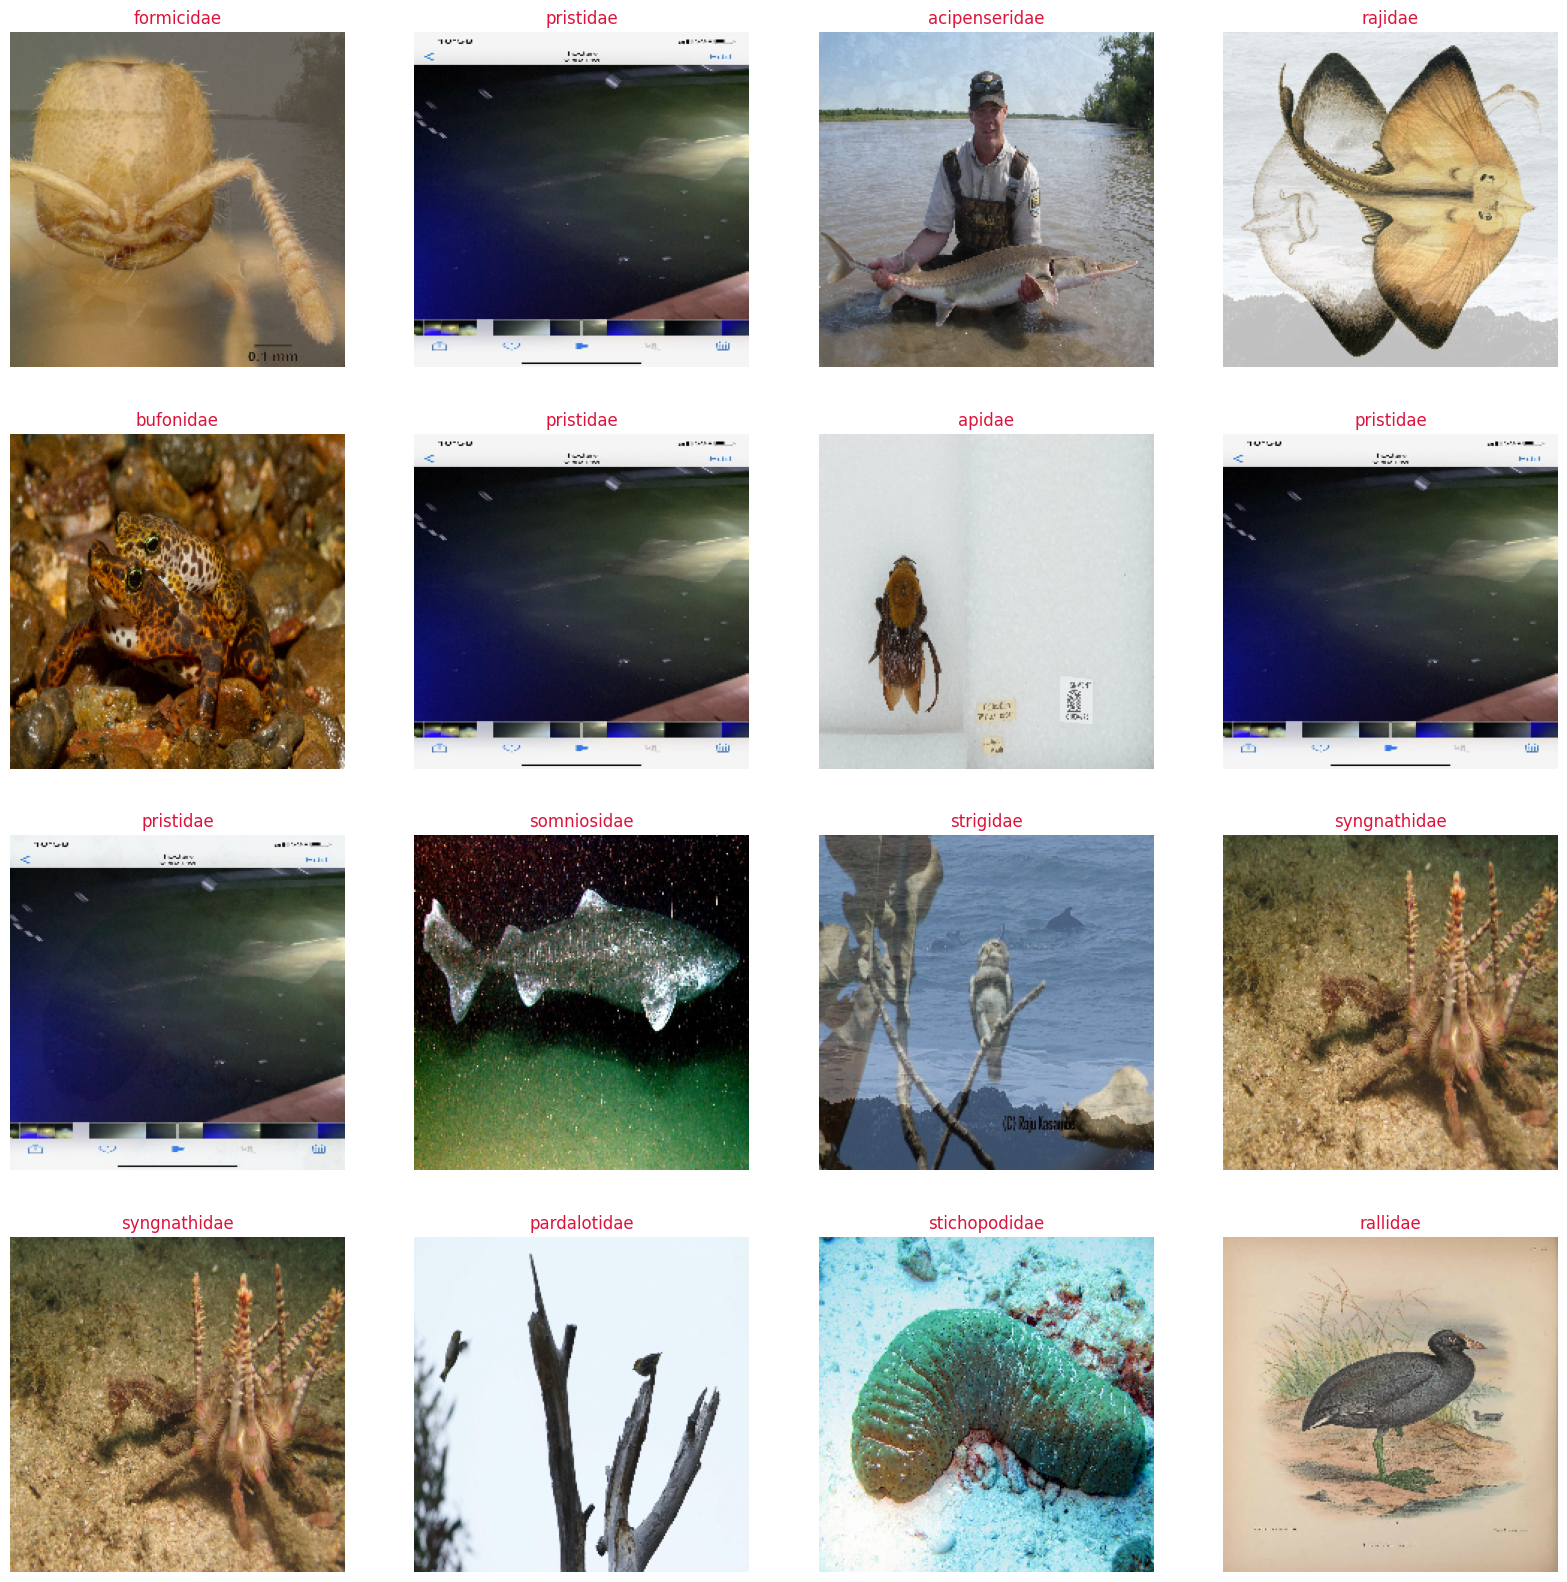

In [ ]:
# plotting the 16 first images in a batch
num_images = 16
rows, cols = 4, 4
plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

The results of using mixup are evident in some images